In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img

import cv2
import itertools
import pathlib
import warnings
import os
import random
import time
import gc
from IPython.display import Markdown, display
from PIL import Image
from random import randint
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout,SeparableConv2D, Activation, BatchNormalization, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG

def printmd(string):   
    display(Markdown(string))
    
np.random.seed(0) # Add random seed of training for reproducibility

def load_images_from_folder(folder,only_path = False, label = ""):
    if only_path == False:
        images = []
        for filename in os.listdir(folder):
            img = plt.imread(os.path.join(folder,filename))
            if img is not None:
                images.append(img)
        return images
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path

In [2]:
images = []
dirp = "/kaggle/input/fruit-recognition/"
for f in os.listdir(dirp):
    if "png" in os.listdir(dirp+f)[0]:
        images += load_images_from_folder(dirp+f,True,label = f)
    else: 
        for d in os.listdir(dirp+f):
            images += load_images_from_folder(dirp+f+"/"+d,True,label = f)
            
df = pd.DataFrame(images, columns = ["fruit", "path"])

from sklearn.utils import shuffle
df = shuffle(df, random_state = 0)
df = df.reset_index(drop=True)

fruit_names = sorted(df.fruit.unique())
mapper_fruit_names = dict(zip(fruit_names, [t for t in range(len(fruit_names))]))
df["label"] = df["fruit"].map(mapper_fruit_names)
print(mapper_fruit_names)

df

{'Apple': 0, 'Banana': 1, 'Carambola': 2, 'Guava': 3, 'Kiwi': 4, 'Mango': 5, 'Orange': 6, 'Peach': 7, 'Pear': 8, 'Persimmon': 9, 'Pitaya': 10, 'Plum': 11, 'Pomegranate': 12, 'Tomatoes': 13, 'muskmelon': 14}


,fruit,path,label
0,Pomegranate,/kaggle/input/fruit-recognition/Pomegranate/Po...,12
1,Pomegranate,/kaggle/input/fruit-recognition/Pomegranate/Po...,12
2,Kiwi,/kaggle/input/fruit-recognition/Kiwi/kiwi A/Ki...,4
3,Mango,/kaggle/input/fruit-recognition/Mango/Mango003...,5
4,Guava,/kaggle/input/fruit-recognition/Guava/Guava to...,3
...,...,...,...
70544,Guava,/kaggle/input/fruit-recognition/Guava/guava B/...,3
70545,Kiwi,/kaggle/input/fruit-recognition/Kiwi/Total Num...,4
70546,Kiwi,/kaggle/input/fruit-recognition/Kiwi/kiwi A/Ki...,4
70547,Kiwi,/kaggle/input/fruit-recognition/Kiwi/kiwi A/Ki...,4


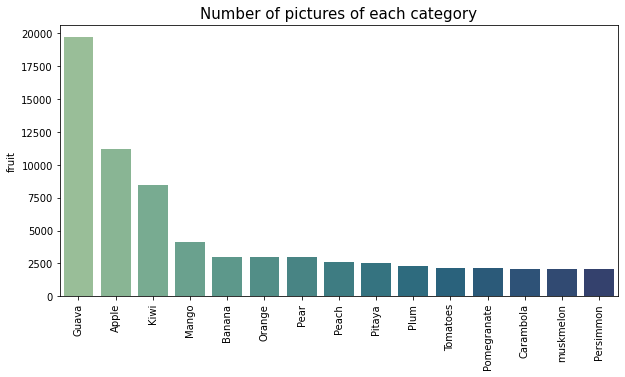

In [3]:
fc = df["fruit"].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x = fc.index, y = fc, palette = "crest")
plt.title("Number of pictures of each category", fontsize = 15)
plt.xticks(rotation=90)
plt.show()

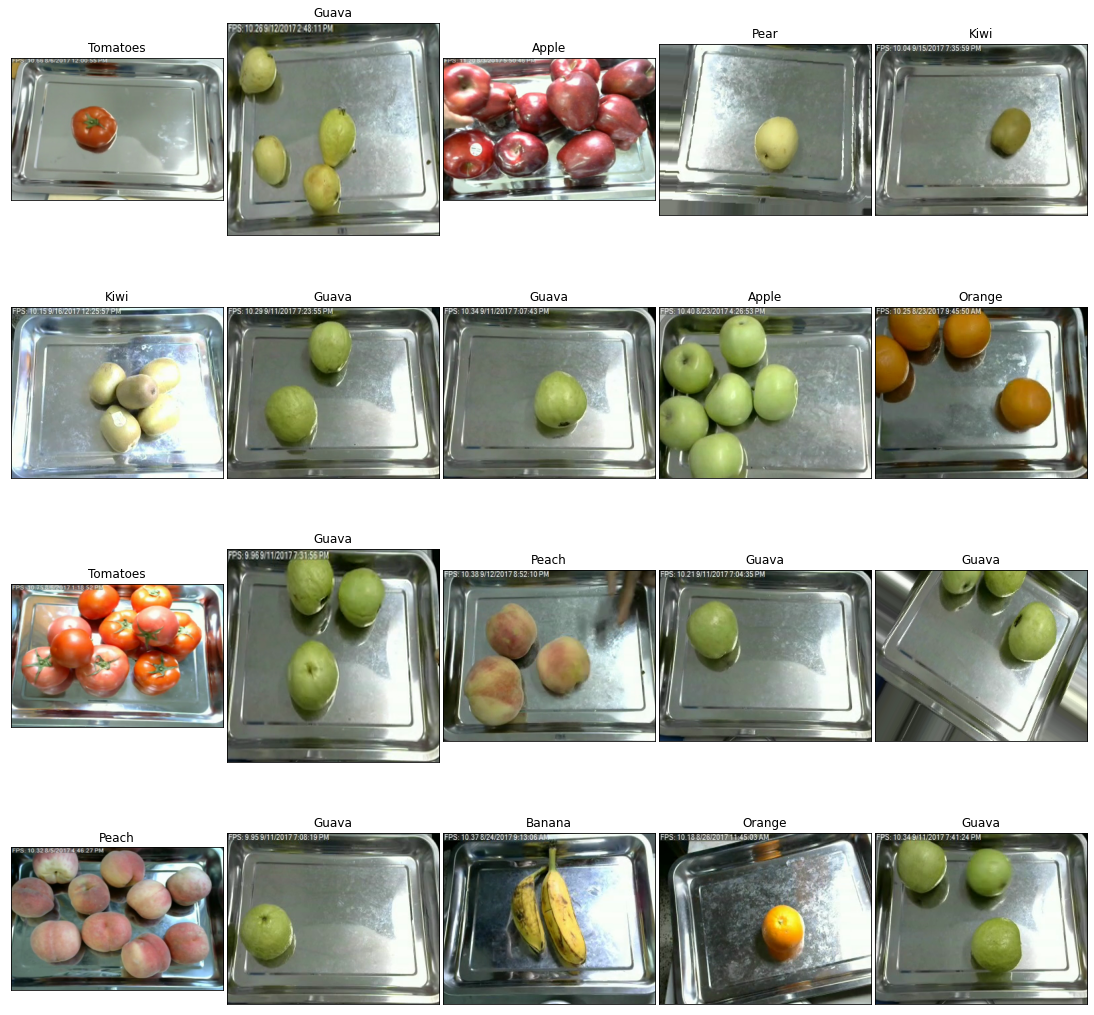

In [4]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.path[i+20]))
    ax.set_title(df.fruit[i+20], fontsize = 12)
plt.tight_layout(pad=0.0)
plt.show()

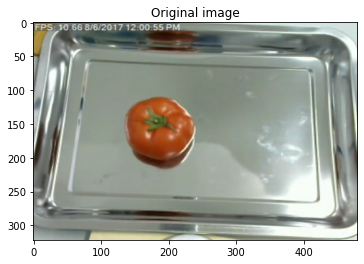

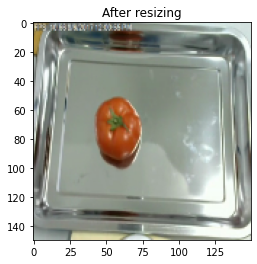

In [5]:
img = plt.imread(df.path[20])
plt.imshow(img)
plt.title("Original image")
plt.show()

plt.imshow(cv2.resize(img, (150,150)))
plt.title("After resizing")
plt.show()

In [6]:
print(df.shape)

(70549, 3)


In [7]:
def cut_df(df, number_of_parts, part):

    if part < 1:
        print("Error, the part should be at least 1")
    elif part > number_of_parts:
        print("Error, the part cannot be higher than the number_of_parts")
        
    number_imgs_each_part = int(df.shape[0]/number_of_parts)
    idx1 = (part-1) * number_imgs_each_part
    idx2 = part * number_imgs_each_part
    return df.iloc[idx1:idx2]

def load_img(df):

    img_paths = df["path"].values
    img_labels = df["label"].values
    X = []
    y = []
    
    for i,path in enumerate(img_paths):
        img =  plt.imread(path)
        img = cv2.resize(img, (150,150))
        label = img_labels[i]
        X.append(img)
        y.append(label)
    return np.array(X),np.array(y)

In [8]:
def create_model():
    shape_img = (150,150,3)
    
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(len(mapper_fruit_names)))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    return model

In [9]:
def from_categorical(lst):
    
    lst = lst.tolist()
    lst2 = []
    for x in lst:
        lst2.append(x.index(max(x)))
    return lst2

def display_stats(y_test, pred):
    print(f"### Result of the predictions using {len(y_test)} test data ###\n")
    y_test_class = from_categorical(y_test)
    print("Classification Report:\n")
    print(classification_report(y_test_class, pred))
    print("\nConfusion Matrix:\n\n")
    print(confusion_matrix(y_test_class, pred))
    print("\n")
    printmd(f"# Accuracy: {round(accuracy_score(y_test_class, pred),5)}")
    
def plot_training(model):
    history = pd.DataFrame(model.history.history)
    history[["accuracy","val_accuracy"]].plot()
    plt.title("Training results")
    plt.xlabel("# epoch")
    plt.show()

In [10]:
model = create_model()
hists = []

divisor = 5

start_time = time.time()
X_train, y_train = load_img(cut_df(df,divisor,1))
y_train = to_categorical(y_train)

callbacks = [EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model.fit(X_train, y_train, batch_size=128, epochs=100, callbacks=callbacks, validation_split = 0.1, verbose = 1)
hists.append(model.history.history)

Epoch 1/100
100/100 [==============================] - 15s 67ms/step - loss: 2.3709 - accuracy: 0.2718 - val_loss: 2.1171 - val_accuracy: 0.2842
Epoch 2/100
100/100 [==============================] - 6s 59ms/step - loss: 1.9095 - accuracy: 0.3676 - val_loss: 1.6548 - val_accuracy: 0.4422
Epoch 3/100
100/100 [==============================] - 6s 58ms/step - loss: 1.4951 - accuracy: 0.4842 - val_loss: 1.4077 - val_accuracy: 0.5138
Epoch 4/100
100/100 [==============================] - 6s 62ms/step - loss: 0.9834 - accuracy: 0.6573 - val_loss: 0.6176 - val_accuracy: 0.7838
Epoch 5/100
100/100 [==============================] - 6s 58ms/step - loss: 0.8887 - accuracy: 0.6956 - val_loss: 0.5969 - val_accuracy: 0.7775
Epoch 6/100
100/100 [==============================] - 6s 59ms/step - loss: 0.5390 - accuracy: 0.8088 - val_loss: 0.4055 - val_accuracy: 0.8540
Epoch 7/100
100/100 [==============================] - 6s 59ms/step - loss: 0.4082 - accuracy: 0.8516 - val_loss: 0.2931 - val_accuracy

In [11]:
gc.collect()

1661

In [12]:
model.save('fruit_model1.h5')

In [13]:
time_model = time.time() - start_time
print(f"Time to train the model: {int(time_model)} seconds")

Time to train the model: 540 seconds


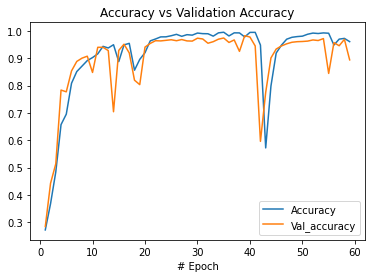

In [14]:
acc = []
val_acc = []
for i in range(len(hists)):
    acc += hists[i]["accuracy"]
    val_acc += hists[i]["val_accuracy"]
hist_df = pd.DataFrame({"# Epoch": [e for e in range(1,len(acc)+1)],"Accuracy": acc, "Val_accuracy": val_acc})
hist_df.plot(x = "# Epoch", y = ["Accuracy","Val_accuracy"])
plt.title("Accuracy vs Validation Accuracy")
plt.show()

In [15]:
import json
with open('history.json', 'w') as f:
    json.dump(hists, f)

In [16]:
temp_1 = cut_df(df,20,20)
temp_1.shape

(3527, 3)

In [17]:
import warnings
warnings.filterwarnings("ignore")

X, y = load_img(cut_df(df, 20, 20))
#pred = model.predict_classes(X)
pred = np.argmax(model.predict(X), axis=1)
y_test = to_categorical(y)

print("### Result of the predictions using {len(y_test)} test data ###\n")
y_test_class = from_categorical(y_test)
# print("Classification Report:\n")
# print(classification_report(y_test_class, pred))
# print("\nConfusion Matrix:\n\n")
# print(confusion_matrix(y_test_class, pred))
# print("\n")
# printmd(f"# Accuracy: {round(accuracy_score(y_test_class, pred),5)}")

### Result of the predictions using {len(y_test)} test data ###



In [18]:
print(f"Result of the predictions using {len(y_test)} test data ###\n")
y_test_class = from_categorical(y_test)
print("Classification Report:\n")
print(classification_report(y_test_class, pred))
# print("\nConfusion Matrix:\n\n")
# print(confusion_matrix(y_test_class, pred))
# print("\n")
# printmd(f"# Accuracy: {round(accuracy_score(y_test_class, pred),5)}")

Result of the predictions using 3527 test data ###

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       545
           1       0.79      0.71      0.75       129
           2       1.00      0.97      0.99       109
           3       0.99      0.96      0.98      1027
           4       0.96      0.96      0.96       395
           5       0.81      0.90      0.86       210
           6       1.00      0.64      0.78       151
           7       0.84      0.80      0.82       127
           8       0.65      0.96      0.78       131
           9       0.67      0.99      0.80       104
          10       0.93      0.87      0.90       131
          11       0.99      0.95      0.97       107
          12       0.92      0.82      0.87       129
          13       0.97      0.89      0.93       129
          14       0.83      0.83      0.83       103

    accuracy                           0.90      3527
   m

<AxesSubplot:>

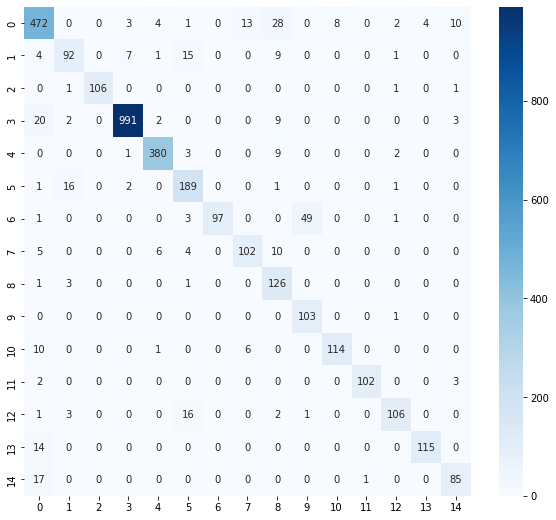

In [19]:
import seaborn as sns
f,ax=plt.subplots(figsize=(10,9))
conf_mat = confusion_matrix(y_test_class, pred)
sns.heatmap(conf_mat,annot=True,fmt='.0f', cmap="Blues")

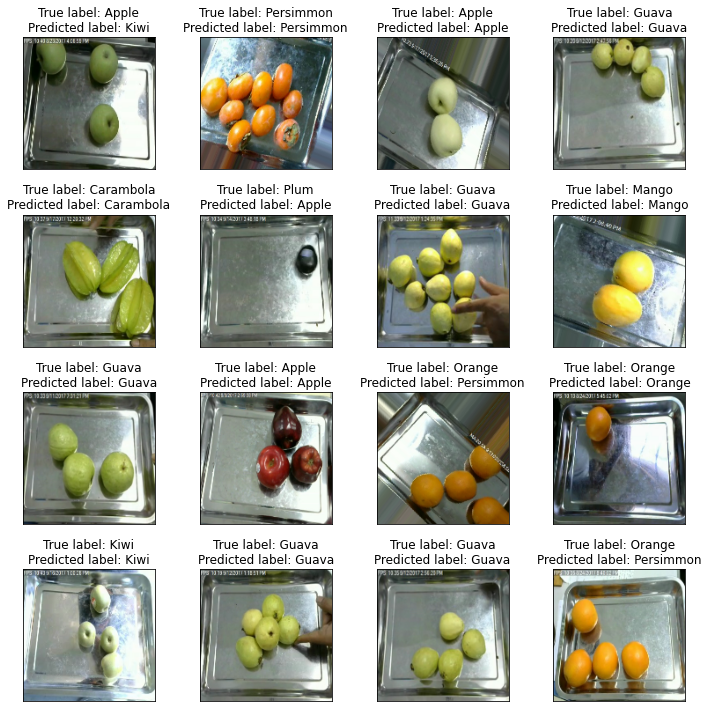

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [20]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(X[-i])
    ax.set_title(f"True label: {fruit_names[y[-i]]}\nPredicted label: {fruit_names[pred[-i]]}")

plt.tight_layout()
plt.show()

for i,ax in enumerate(axes.flat):
    print(i)